# Trade Smarter w/ Reinforcement Learning
## A deep dive into TensorTrade - the Python framework for trading and investing using deep reinforcement learning

![Banner](img/banner.jpeg)

Winning high stakes poker tournaments, beating world-class StarCraft players, and autonomously driving Tesla's futuristic sports cars. What do they all have in common? Each of these extremely complex tasks were long thought to be impossible by machines, until only recently being made possible through the massive advancements in deep reinforcement learning. 

Reinforcement learning is beginning to take over the world.

![Source: https://deepmind.com/blog/article/alphastar-mastering-real-time-strategy-game-starcraft-ii](img/alphastar.gif)

A little over two months ago, I decided I wanted to take part in the revolution, so I set out on a journey to create a profitable Bitcoin trading strategy using state-of-the-art deep reinforcement learning algorithms. While I made quite a bit of progress on that front, I realized that the tooling for this sort of project can be quite daunting to wrap your head around, and as such, it is very easy to get lost in the details.

In between optimizing my previous project for distributed high-performance computing (HPC) systems; getting lost in endless pipelines of data and feature optimizations; and running my head in circles around efficient model set-up, tuning, training, and evaluation; I realized that there had to be a better way of doing things. After countless hours of researching existing projects, spending endless nights watching PyData conference talks, and having many back-and-forth conversations with the hundreds of members of the  RL trading Discord community, I realized there weren't any existing solutions that were all that good.

There were many bits and pieces of great reinforcement learning trading systems spread across the inter-webs, but nothing solid and complete. For this reason, I've decided to create an open source Python framework for getting any trading strategy from idea to production, efficiently, using deep reinforcement learning. 

Enter TensorTrade. The idea was to create a highly modular framework for building efficient reinforcement learning trading strategies in a composable, maintainable way. Sounds like a mouthful of buzz-words if you ask me, so let's get into the meat.

# Overview

![Logo](img/logo.jpeg)

TensorTrade is an open source Python framework for training, evaluating, and deploying robust trading strategies using deep reinforcement learning. The framework focuses on being highly composable and extensible, to allow the system to scale from simple trading strategies on a single CPU, to complex investment strategies run on a distribution of HPC machines.

Under the hood, the framework uses many of the APIs from existing machine learning libraries to maintain high quality data pipelines and learning models. One of the main goals of TensorTrade is to enable fast experimentation with algorithmic trading strategies, by leveraging the existing tools and pipelines provided by `numpy`, `pandas`, `gym`, `keras`, and `tensorflow`.

The aim is to simplify the process of testing and deploying robust trading agents using deep reinforcement learning, to allow you and I to focus on creating profitable strategies.

## RL Primer

In case your reinforcement learning chops are a bit rusty, let's quickly go over the basic concepts.

Every reinforcement learning problem starts out with an environment and one or more agents that can interact with the environment.

![Primer](img/primer.jpg)

_This technique is based off Markov Decision Processes (MDP) dating back to the 1950s._

The agent will first observe the environment, then build a model of the current state and the expected value of actions within that environment. Based on that model, the agent will then take the action it has deemed as having the highest expected value.

Based on the effects of the chosen action within the environment, the agent will be rewarded by an amount corresponding to the actual value of that action. The reinforcement learning agent can then, through the process of trial and error (i.e. learning through reinforcement), improve its underlying model and learn to take more rewarding actions over time.

If you still need a bit of refreshment on the subject, there is a link to an article titled _Introduction to Deep Reinforcement Learning_ in the references for this article, which goes much more in-depth into the details. Let's move on.

## Getting Started

The following tutorial should provide enough examples to get you started with creating simple trading strategies using TensorTrade, although you will quickly see the framework is capable of handling much more complex configurations.

## Installation

TensorTrade requires Python 3.6 or later, so make sure you're using a valid version before pip installing the framework. 

In [2]:
import os
import sys
import warnings
import numpy

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))

To follow this entire tutorial, you will need to install some extra dependencies, such as `tensorflow`, `stable-baselines`, `tensorforce`, `ccxt`, and `stochastic`.

In [3]:
!pip install -e ..[tf,tensorforce,baselines,ccxt,fbm] -U

Obtaining file:///home/kevin/Code/Tools/tensortrade


  Found existing installation: tensortrade 0.1.0rc1
    Uninstalling tensortrade-0.1.0rc1:
      Successfully uninstalled tensortrade-0.1.0rc1
  Running setup.py develop for tensortrade


That's all the installation necessary! Let's get into the code.

# TensorTrade Components

TensorTrade is built around modular components that together make up a trading strategy. Trading strategies combine reinforcement learning agents with composable trading logic in the form of a `gym` environment. A trading environment is made up of a set of modular components that can be mixed and matched to create highly diverse trading and investment strategies. I will explain this in further detail later, but for now it is enough to know the basics.

![Components](img/components.jpeg)

Just like electrical components, the purpose of TensorTrade components is to be able to mix and match them as necessary.

_The code snippets in this section should serve as guidelines for creating new strategies and components. There will likely be missing implementation details that will become more clear in a later section, as more components are defined._

## Trading Environment

A trading environment is a reinforcement learning environment that follows OpenAI's `gym.Env` specification. This allows us to leverage many of the existing reinforcement learning models in our trading agent, if we'd like.

![Environment](img/environment.jpeg)

Each environment is a fully configurable `gym` environment with highly composable `Exchange`, `FeaturePipeline`, `ActionScheme`, and `RewardScheme` components.

* The `Exchange` provides observations to the environment and executes the agent's trades.
* The `FeaturePipeline` optionally transforms the exchange output into a more meaningful set of features before it is passed to the agent.
* The `ActionScheme` converts the agent's actions into executable trades.
* The `RewardScheme` calculates the reward for each time step based on the agent's performance.

If it seems a bit complicated now, it's really not. That is all there is to it, now it's just a matter of composing each of these components into a complete environment.

When the reset method of a `TradingEnvironment` is called, all of the child components will also be reset. The internal state of each exchange, feature pipeline, transformer, action scheme, and reward scheme will be set back to their default values, ready for the next episode.

Let's begin with an example environment. As mentioned before, initializing a `TradingEnvironment` requires an exchange, an action scheme, and a reward scheme, the feature pipeline is optional.

_While the recommended use case is to plug a trading environment into a trading strategy, you can obviously use the trading environment separately, however you'd like._

## Exchanges

Exchanges determine the universe of tradable instruments within a trading environment, return observations to the environment on each time step, and execute trades made within the environment. There are two types of exchanges: live and simulated. 

Live exchanges are implementations of `Exchange` backed by live pricing data and a live trade execution engine. For example, `CCXTExchange` is a live exchange, which is capable of returning pricing data and executing trades on hundreds of live cryptocurrency exchanges, such as Binance and [Coinbase](https://coinbase-consumer.sjv.io/c/1949163/626313/9251). 

In [4]:
import ccxt
from tensortrade.exchanges.live import CCXTExchange

coinbase = ccxt.coinbasepro()
exchange = CCXTExchange(exchange=coinbase, base_instrument='USD')

TypeError: float() argument must be a string or a number, not 'NoneType'

Simulated exchanges, on the other hand, are implementations of `Exchange` backed by simulated pricing data and trade execution. For example, `FBMExchange` is a simulated exchange, which generates pricing and volume data using fractional brownian motion (FBM). Since its price is simulated, the trades it executes must be simulated as well. The exchange uses a simple slippage model to simulate price and volume slippage on trades, though like almost everything in TensorTrade, this slippage model can easily be swapped out for something more complex.

Though the `FBMExchange` generates fake price and volume data using a stochastic model, it is simply an implementation of `SimulatedExchange`. Under the hood, `SimulatedExchange` only requires a `data_frame` of price history to generate its simulations. This data_frame can either be provided by a coded implementation such as `FBMExchange`, or at runtime such as in the following example.

In [5]:
import pandas as pd
from tensortrade.exchanges.simulated import SimulatedExchange

df = pd.read_csv('data/Coinbase_BTCUSD_1h.csv', skiprows=1)
exchange = SimulatedExchange(data_frame=df, base_instrument='USD', pretransform=True)

exchange.data_frame

,date,symbol,open,high,low,close,volume_btc,volume
0,2019-10-17 09-AM,BTCUSD,8051.00,8056.83,8021.23,8035.88,61.25,492394.56
1,2019-10-17 08-AM,BTCUSD,7975.89,8070.00,7975.89,8051.00,370.45,2971610.86
2,2019-10-17 07-AM,BTCUSD,7964.62,7987.82,7964.61,7975.89,121.68,970521.83
3,2019-10-17 06-AM,BTCUSD,7984.02,7993.97,7958.29,7964.62,212.35,1692336.84
4,2019-10-17 05-AM,BTCUSD,7941.71,7986.99,7937.01,7984.02,97.26,774064.91
5,2019-10-17 04-AM,BTCUSD,7970.19,7973.23,7937.50,7941.71,147.90,1177321.50
6,2019-10-17 03-AM,BTCUSD,7986.62,7988.54,7965.61,7970.19,100.90,805106.70
7,2019-10-17 02-AM,BTCUSD,7960.00,7989.62,7959.74,7986.62,93.28,743583.37
8,2019-10-17 01-AM,BTCUSD,7966.43,7977.48,7959.74,7960.00,166.35,1325771.25
9,2019-10-17 12-AM,BTCUSD,7993.54,7995.81,7957.55,7966.43,198.66,1584534.00


## Feature Pipelines

Feature pipelines are meant for transforming observations from the environment into meaningful features for an agent to learn from. If a pipeline has been added to a particular exchange, then observations will be passed through the `FeaturePipeline` before being output to the environment. For example, a feature pipeline could normalize all price values, make a time series stationary, add a moving average column, and remove an unnecessary column, all before the observation is returned to the agent.

![Pipeline](img/pipeline.jpeg)

Feature pipelines can be initialized with an arbitrary number of comma-separated transformers. Each `FeatureTransformer` needs to be initialized with the set of columns to transform, or if nothing is passed, all input columns will be transformed.

Each feature transformer has a transform method, which will transform a single observation (a `pandas.DataFrame`) from a larger data set, keeping any necessary state in memory to transform the next frame. For this reason, it is often necessary to reset the `FeatureTransformer` periodically. This is done automatically each time the parent `FeaturePipeline` or `Exchange` is reset.

Let's create an example pipeline and add it to our existing exchange.

In [7]:
from tensortrade.features import FeaturePipeline
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features.stationarity import FractionalDifference

normalize_price = MinMaxNormalizer(["open", "high", "low", "close"])
difference_all = FractionalDifference(difference_order=0.6)

feature_pipeline = FeaturePipeline(steps=[normalize_price, difference_all])

exchange.feature_pipeline = feature_pipeline

exchange.data_frame

,date,symbol,open,high,low,close,volume_btc,volume
0,2019-10-17 09-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
1,2019-10-17 08-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
2,2019-10-17 07-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
3,2019-10-17 06-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
4,2019-10-17 05-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
5,2019-10-17 04-AM,BTCUSD,1.349124e-05,1.319207e-05,1.323022e-05,1.294776e-05,43.401360,3.443566e+05
6,2019-10-17 03-AM,BTCUSD,1.219655e-05,1.210733e-05,1.220763e-05,1.214481e-05,-24.981546,-1.976999e+05
7,2019-10-17 02-AM,BTCUSD,1.078930e-05,1.101981e-05,1.096712e-05,1.115788e-05,-7.368312,-5.929822e+04
8,2019-10-17 01-AM,BTCUSD,1.016654e-05,1.006117e-05,1.015525e-05,9.958366e-06,74.411543,5.926411e+05
9,2019-10-17 12-AM,BTCUSD,9.743370e-06,9.636891e-06,9.454589e-06,9.483322e-06,65.332294,5.216977e+05


_This feature pipeline normalizes the price values between 0 and 1, before making the entire time series stationary by fractionally differencing consecutive values._

## Action Strategies

Action schemes define the action space of the environment and convert an agent's actions into executable trades. For example, if we were using a discrete action space of 3 actions (0 = `hold`, 1 = `buy 100%`, 2 = `sell 100%`), our learning agent does not need to know that returning an action of 1 is equivalent to buying an instrument. Rather, our agent needs to know the reward for returning an action of 1 in specific circumstances, and can leave the implementation details of converting actions to trades to the `ActionScheme`.

Each action scheme has a get_trade method, which will transform the agent's specified action into an executable `Trade`. It is often necessary to store additional state within the scheme, for example to keep track of the currently traded position. This state should be reset each time the action scheme's reset method is called, which is done automatically when the parent `TradingEnvironment` is reset.

In [15]:
from tensortrade.actions import DiscreteActions

action_scheme = DiscreteActions(n_actions=20, instrument='BTC')

_This discrete action scheme uses 20 discrete actions, which equates to 4 discrete amounts for each of the 5 trade types (market buy/sell, limit buy/sell, and hold). E.g. [0,5,10,15]=hold, 1=market buy 25%, 2=market sell 25%, 3=limit buy 25%, 4=limit sell 25%, 6=market buy 50%, 7=market sell 50%, etc…_

## Reward Strategies

Reward schemes receive the trade taken at each time step and return a float, corresponding to the benefit of that specific action. For example, if the action taken this step was a sell that resulted in positive profits, our `RewardScheme` could return a positive number to encourage more trades like this. On the other hand, if the action was a sell that resulted in a loss, the scheme could return a negative reward to teach the agent not to make similar actions in the future.

A version of this example algorithm is implemented in `SimpleProfit`, however more complex schemes can obviously be used instead.

Each reward scheme has a get_reward method, which takes in the trade executed at each time step and returns a float corresponding to the value of that action. As with action schemes, it is often necessary to store additional state within a reward scheme for various reasons. This state should be reset each time the reward scheme's reset method is called, which is done automatically when the parent `TradingEnvironment` is reset.

In [16]:
from tensortrade.rewards import SimpleProfit

reward_scheme = SimpleProfit()

_The simple profit strategy returns a reward of -1 for not holding a trade, 1 for holding a trade, 2 for purchasing an instrument, and a value corresponding to the (positive/negative) profit earned by a trade if an instrument was sold._

## Learning Agents

Up until this point, we haven't seen the "deep" part of the deep reinforcement learning framework. This is where learning agents come in. Learning agents are where the math (read: magic) happens.

![Agent](img/agents.jpeg)

At each time step, the agent takes the observation from the environment as input, runs it through its underlying model (a neural network most of the time), and outputs the action to take. For example, the observation might be the previous open, high, low, and close price from the exchange. The learning model would take these values as input and output a value corresponding to the action to take, such as buy, sell, or hold.

It is important to remember the learning model has no intuition of the prices or trades being represented by these values. Rather, the model is simply learning which values to output for specific input values or sequences of input values, to earn the highest reward.

## Stable Baselines

In this example, we will be using the Stable Baselines library to provide learning agents to our trading strategy, however, the TensorTrade framework is compatible with many reinforcement learning libraries such as Tensorforce, Ray's RLLib, OpenAI's Baselines, Intel's Coach, or anything from the TensorFlow line such as TF Agents.

It is possible that custom TensorTrade learning agents will be added to this framework in the future, though it will always be a goal of the framework to be interoperable with as many existing reinforcement learning libraries as possible, since there is so much concurrent growth in the space.

But for now, Stable Baselines is simple and powerful enough for our needs.

_Note: Stable Baselines is not required to use TensorTrade though it is required for this tutorial. This example uses a GPU-enabled Proximal Policy Optimization model with a layer-normalized LSTM perceptron network. If you would like to know more about Stable Baselines, you can view the [Documentation](https://stable-baselines.readthedocs.io/en/master/)._

## Tensorforce

I will also quickly cover the Tensorforce library to show how simple it is to switch between reinforcement learning frameworks.

_If you would like to know more about Tensorforce agents, you can view the [Documentation](https://tensorforce.readthedocs.io/en/0.4.4)._

## Trading Strategy

A `TradingStrategy` consists of a learning agent and one or more trading environments to tune, train, and evaluate on. If only one environment is provided, it will be used for tuning, training, and evaluating. Otherwise, a separate environment may be provided at each step.

_Don't worry if you don't understand the strategy initialization just yet, it will be explained in more detail later._

# Putting it All Together

Now that we know about each component that makes up a `TradingStrategy`, let's build and evaluate one.

![Tuning](img/tuning.jpeg)

For a quick recap, a `TradingStrategy` is made up of a `TradingEnvironment` and a learning agent. A `TradingEnvironment` is a gym environment that takes an `Exchange`, an `ActionScheme`, a `RewardScheme`, and an optional `FeaturePipeline`, and returns observations and rewards that the learning agent can be trained and evaluated on.

## Creating an Environment

The first step is to create a `TradingEnvironment` using the components outlined above.

In [18]:
from tensortrade.environments import TradingEnvironment

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme)

KeyboardInterrupt: 

Simple enough, now `environment` is a `gym` environment that can be used by any compatible trading strategy or learning agent.

## Defining the Agent

Now that the environment is set up, it’s time to create our learning agent. Again, we will be using Stable Baselines for this, but feel free to drop in any other reinforcement learning agent here.

Since we are using `StableBaselinesTradingStrategy`, all we need to do is provide a model type and a policy type for the underlying neural network to be trained. For this example, we will be using a simple proximal policy optimization (PPO) model and a layer-normalized LSTM policy network.

For more examples of model and policy specifications, see the [Stable Baselines Documentation](http://stable-baselines.readthedocs.io/en/master/).

In [ ]:
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines import PPO2

model = PPO2
policy = MlpLnLstmPolicy
params = { "learning_rate": 1e-5, 'nminibatches': 1 }

## Training a Strategy

Creating our trading strategy is as simple as plugging in our agent and the environment.

In [10]:
from tensortrade.strategies import StableBaselinesTradingStrategy

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

Then to train the strategy (i.e. train the agent on the current environment), all we need to do is call `strategy.run()` with the total number of steps or episodes you’d like to run.

In [11]:
performance = strategy.run(steps=10000)

Finished running strategy.
Total episodes: 0 (10000 timesteps).
Average reward: -0.38326355742842805.


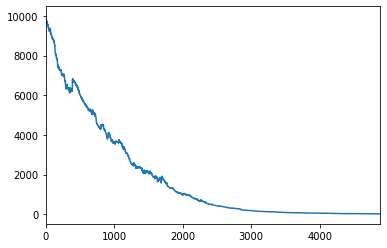

In [12]:
%matplotlib inline

performance.net_worth.plot()

If this feedback loop is a bit slow for you, you can pass a callback function to `run`, which will be called at the end of each episode. The callback function will pass in a `data_frame` containing the agent's performance that episode, and expects a `bool` in return. If `True`, the agent will continue training, otherwise, the agent will stop and return its overall performance.

## Saving and Restoring

All trading strategies are capable of saving their agent to a file, for later restoring. The environment is not saved, as it does not have state that we care about preserving. To save our `TensorflowTradingStrategy` to a file, we just need to provide the path of the file to our strategy.

In [13]:
strategy.save_agent(path="agents/ppo_btc_1h")

_This specific strategy saves multiple files, including a directory of models to the path provided._

To restore the agent from the file, we first need to instantiate our strategy, before calling restore_agent.

In [14]:
new_strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

new_strategy.restore_agent(path="agents/ppo_btc_1h")

Our strategy is now restored back to its previous state, and ready to be used again. Let's see how it does.

## Tuning Your Strategy

Sometimes a trading strategy will require tuning a set of hyper-parameters, or features, on an environment to achieve maximum performance. In this case, each `TradingStrategy` provides an optionally implementable tune method.

Tuning a model is similar to training a model, however in addition to adjusting and saving the weights and biases of the best performing model, the strategy also adjusts and persists the hyper-parameters that produced that model. 

In this case, the agent will be trained for 10 episodes, with a different set of hyper-parameters each episode. The best set will be saved within the strategy, and used any time strategy.run() is called thereafter.

## Strategy Evaluation

Now that we've tuned and trained our agent, it's time to see how well it performs. To evaluate our strategy's performance on unseen data, we will need to run it on a new environment backed by such data.

In [15]:
import pandas as pd
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.simulated import SimulatedExchange

df = pd.read_csv('data/Coinbase_BTCUSD_d.csv', skiprows=1)
exchange = SimulatedExchange(data_frame=df,
                             feature_pipeline=feature_pipeline,
                             base_instrument='USD',
                             pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme)

new_strategy.environment = environment

test_performance = new_strategy.run(steps=2000)

Finished running strategy.
Total episodes: 1 (2000 timesteps).
Average reward: -0.7945276696372455.


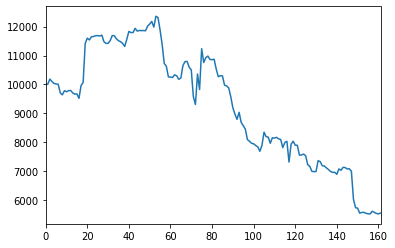

In [16]:
%matplotlib inline

test_performance.net_worth.plot()

When complete, strategy.run returns a `Pandas.data_frame` of the agent's performance, including the net worth and balance of the agent at each time step.

## Live Trading

Once you've built a profitable trading strategy, trained an agent to trade it properly, and ensured its "generalize-ability" to new data sets, all there is left to do is profit. Using a live exchange such as `CCXTExchange`, you can plug your strategy in and let it run!

![Trading](img/trading.jpeg)

While the gambler in you may enjoy starting a strategy and letting it run without bounds, the more risk averse of you can use a `trade_callback`, which will be called each time the strategy makes a trade. This callback function, similar to the episode callback, will pass in a data frame containing the agent's overall performance, and expects a `bool` in return. If `True`, the agent will continue trading, otherwise, the agent will stop and return its performance over the session.

In [20]:
import ccxt
from tensortrade.environments import TradingEnvironment
from tensortrade.exchanges.live import CCXTExchange

binance = ccxt.binance({
    'apiKey': 'HfPX38sJ2aKewYDUJx6TaWrDhuT7rq426elO5Gbc55Dvg4klASEfm0aqcdl4Mpz6',
    'secret': 'aGdMMaaol3GkyzDcrSEoc4aFlWG78qCxnGl3o22ub24u2scrZRcsIe2qn0kI82GQ',
    'enableRateLimit': True,
})

exchange = CCXTExchange(exchange=binance,
                        base_instrument='BNB',
                        observation_type='ohlcv',
                        timeframe='1h')

btcusd_actions = DiscreteActions(n_actions=20, instrument='BNB/BTC')

environment = TradingEnvironment(exchange=exchange,
                                 feature_pipeline=feature_pipeline,
                                 action_scheme=btcusd_actions,
                                 reward_scheme=reward_scheme)

strategy.environment = environment

live_performance = strategy.run(steps=1)

Finished running strategy.
Total episodes: 0 (1 timesteps).
Average reward: -0.5.


In [21]:
live_performance

{}

_Passing `steps=0` instructs the strategy to run until otherwise stopped._

That's all there is to it! As you can see, it is quite simple to build complex trading strategies using simple components and deep reinforcement learning. So what are you waiting for? Dive in, get your hands dirty, and see what's possible using TensorTrade.

# Final Thoughts

TensorTrade is a powerful framework capable of building highly modular, high performance trading systems. It is fairly simple and easy to experiment with new trading and investment strategies, while allowing you to leverage components from one strategy in another. But don't take my word for it, create a strategy of your own and start teaching your robots to take over the world!

While this tutorial should be enough to get you started, there is still quite a lot more to learn if you want to create a profitable trading strategy. I encourage you to head over to the [Github](https://github.com/notadamking/tensortrade) and dive into the codebase, or take a look at our documentation at [tensortrade.org](https://tensortrade.org). There is also quite an active [Discord community](https://discord.gg/ZZ7BGWh) with nearly 1000 total members, so if you have questions, feedback, or feature requests, feel free to drop them there!

![Commits](img/commits.png)

I've gotten the project to a highly usable state. Though, my time is limited, and I believe there are many of you out there who could make valuable contributions to the open source codebase. So if you are a developer or data scientist with an interest in building state-of-the-art trading systems, I'd love to see you open a pull request, even if its just a simple test case!

Others have asked how they can contribute to the project without writing code. There are currently three ways that you can do that. 

1. Write code or documentation for the TensorTrade framework. Many issues on the Github are funded through Gitcoin smart contracts, so you can actually get paid to contribute.

2. Fund this project with either [Bitcoin](https://www.blockchain.com/btc/address/1Lc47bhYvdyKGk1qN8oBHdYQTkbFLL3PFw) or [Ethereum](https://www.blockchain.com/eth/address/0x9907A0cF64Ec9Fbf6Ed8FD4971090DE88222a9aC). These donations are used to fund our Gitcoin smart contracts, which allows anyone who contributes quality code and documentation to get paid for their contributions.

3. Sponsor me on [Patreon](https://www.patreon.com/notadamking). Your support means a lot to me, and allows me to continue spending my time working on the framework and writing articles like this. All patrons have gotten early access to this article and codebase, and will continue to get early access to any articles I write in the future as a thank you.

Thanks for reading! As always, all of the code for this tutorial can be found on my [GitHub](https://github.com/notadamking/tensortrade). Leave a comment below if you have any questions or feedback, I'd love to hear from you! I can also be reached on [Twitter](https://twitter.com/notadamking) at @notadamking.

## References

[1.] Introduction to Deep Reinforcement Learning Hui, Jonathan. "RL- Introduction to Deep Reinforcement Learning." Medium, 7 Jan. 2019, https://medium.com/@jonathan_hui/rl-introduction-to-deep-reinforcement-learning-35c25e04c199.

[2.] Policy Gradient Algorithms
Weng, Lilian. "Policy Gradient Algorithms." Lil'Log, 8 Apr. 2018, https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce.

[3.] Clean Code: A Handbook of Agile Software Craftsmanship
[Martin, Robert C. Clean Code: a Handbook of Agile Software Craftsmanship. Prentice Hall, 2010](https://amzn.to/2XANX1X).

[4.] Advances in Financial Machine Learning
[Prado Marcos López de. Advances in Financial Machine Learning. Wiley, 2018](https://amzn.to/2J6YCrW).